In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import colorcet as cc
import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from importlib import reload
from typing import List, Dict, Tuple
import celeri

plt.rcParams["text.usetex"] = False

# Read input, create data structures, close blocks


In [3]:
COMMAND_FILE_NAME = "../data/command/anatolia_command.json"
command = celeri.get_command(COMMAND_FILE_NAME)
celeri.create_output_folder(command)
logger = celeri.get_logger(command)
segment, block, meshes, station, mogi, sar = celeri.read_data(command)

# TODO: CHECK WHATEVER THIS IS
# Hack
segment.locking_depth = 15
segment.burial_depth = 0
segment.locking_depth.values[segment.patch_flag == 1] = 0
segment.burial_depth.values[segment.patch_flag == 1] = 0

station = celeri.process_station(station, command)
segment = celeri.process_segment(segment, command, meshes)
sar = celeri.process_sar(sar, command)
closure, block = celeri.assign_block_labels(segment, station, block, mogi, sar)
assembly = addict.Dict()
operators = addict.Dict()
operators.meshes = [addict.Dict()] * len(meshes)
assembly = celeri.merge_geodetic_data(assembly, station, sar)

2023-02-20 23:04:03.211 | INFO     | celeri.celeri:get_logger:122 - Read: ../data/command/western_north_america_command.json
2023-02-20 23:04:03.211 | INFO     | celeri.celeri:get_logger:123 - RUN_NAME: 2023-02-20-23-04-03
2023-02-20 23:04:03.211 | INFO     | celeri.celeri:get_logger:124 - Write log file: ../runs/2023-02-20-23-04-03/2023-02-20-23-04-03.log
2023-02-20 23:04:03.212 | INFO     | celeri.celeri:read_data:129 - Reading data files
2023-02-20 23:04:03.217 | SUCCESS  | celeri.celeri:read_data:133 - Read: ../data/segment/western_north_america_segment.csv
2023-02-20 23:04:03.219 | SUCCESS  | celeri.celeri:read_data:138 - Read: ../data/block/western_north_america_block.csv
2023-02-20 23:04:03.220 | SUCCESS  | celeri.celeri:read_data:145 - Read: ../data/mesh/western_north_america_mesh_parameters.json



Warning: The file contains tag data that couldn't be processed.

2023-02-20 23:04:03.245 | SUCCESS  | celeri.celeri:read_data:265 - Read: ../data/mesh/cascadia.msh
2023-02-20 23:04:03.249 | SUCCESS  | celeri.celeri:read_data:301 - Read: ../data/station/western_north_america_station.csv
2023-02-20 23:04:03.250 | INFO     | celeri.celeri:read_data:316 - No mogi_file_name
2023-02-20 23:04:03.251 | INFO     | celeri.celeri:read_data:338 - No sar_file_name


# Get elastic operators and TDE smoothing operators


In [4]:
# Get all elastic operators for segments and TDEs
celeri.get_elastic_operators(operators, meshes, segment, station, command)

# Get TDE smoothing operators
celeri.get_all_mesh_smoothing_matrices(meshes, operators)

2023-02-20 23:04:03.957 | INFO     | celeri.celeri:get_elastic_operators:1524 - Using precomputed elastic operators


# Calculate non-elastic operators


In [5]:
n_blocks = len(block)
operators.rotation_to_velocities = celeri.get_rotation_to_velocities_partials(
    station, n_blocks
)
operators.global_float_block_rotation = celeri.get_global_float_block_rotation_partials(
    station
)
assembly, operators.block_motion_constraints = celeri.get_block_motion_constraints(
    assembly, block, command
)
assembly, operators.slip_rate_constraints = celeri.get_slip_rate_constraints(
    assembly, segment, block, command
)
operators.rotation_to_slip_rate = celeri.get_rotation_to_slip_rate_partials(
    segment, block
)
(
    operators.block_strain_rate_to_velocities,
    strain_rate_block_index,
) = celeri.get_block_strain_rate_to_velocities_partials(block, station, segment)
operators.mogi_to_velocities = celeri.get_mogi_to_velocities_partials(
    mogi, station, command
)
celeri.get_tde_slip_rate_constraints(meshes, operators)

2023-02-20 23:04:04.583 | INFO     | celeri.celeri:get_slip_rate_constraints:1163 - Found 1 slip rate constraints
2023-02-20 23:04:04.586 | INFO     | celeri.celeri:get_slip_rate_constraints:1166 - Strike-slip rate constraint on cfm_san_andreas_mojave_extruded_trace_part1_sa: rate = -50.00 (mm/yr), 1-sigma uncertainty = +/-1.00 (mm/yr)


# Plot input data


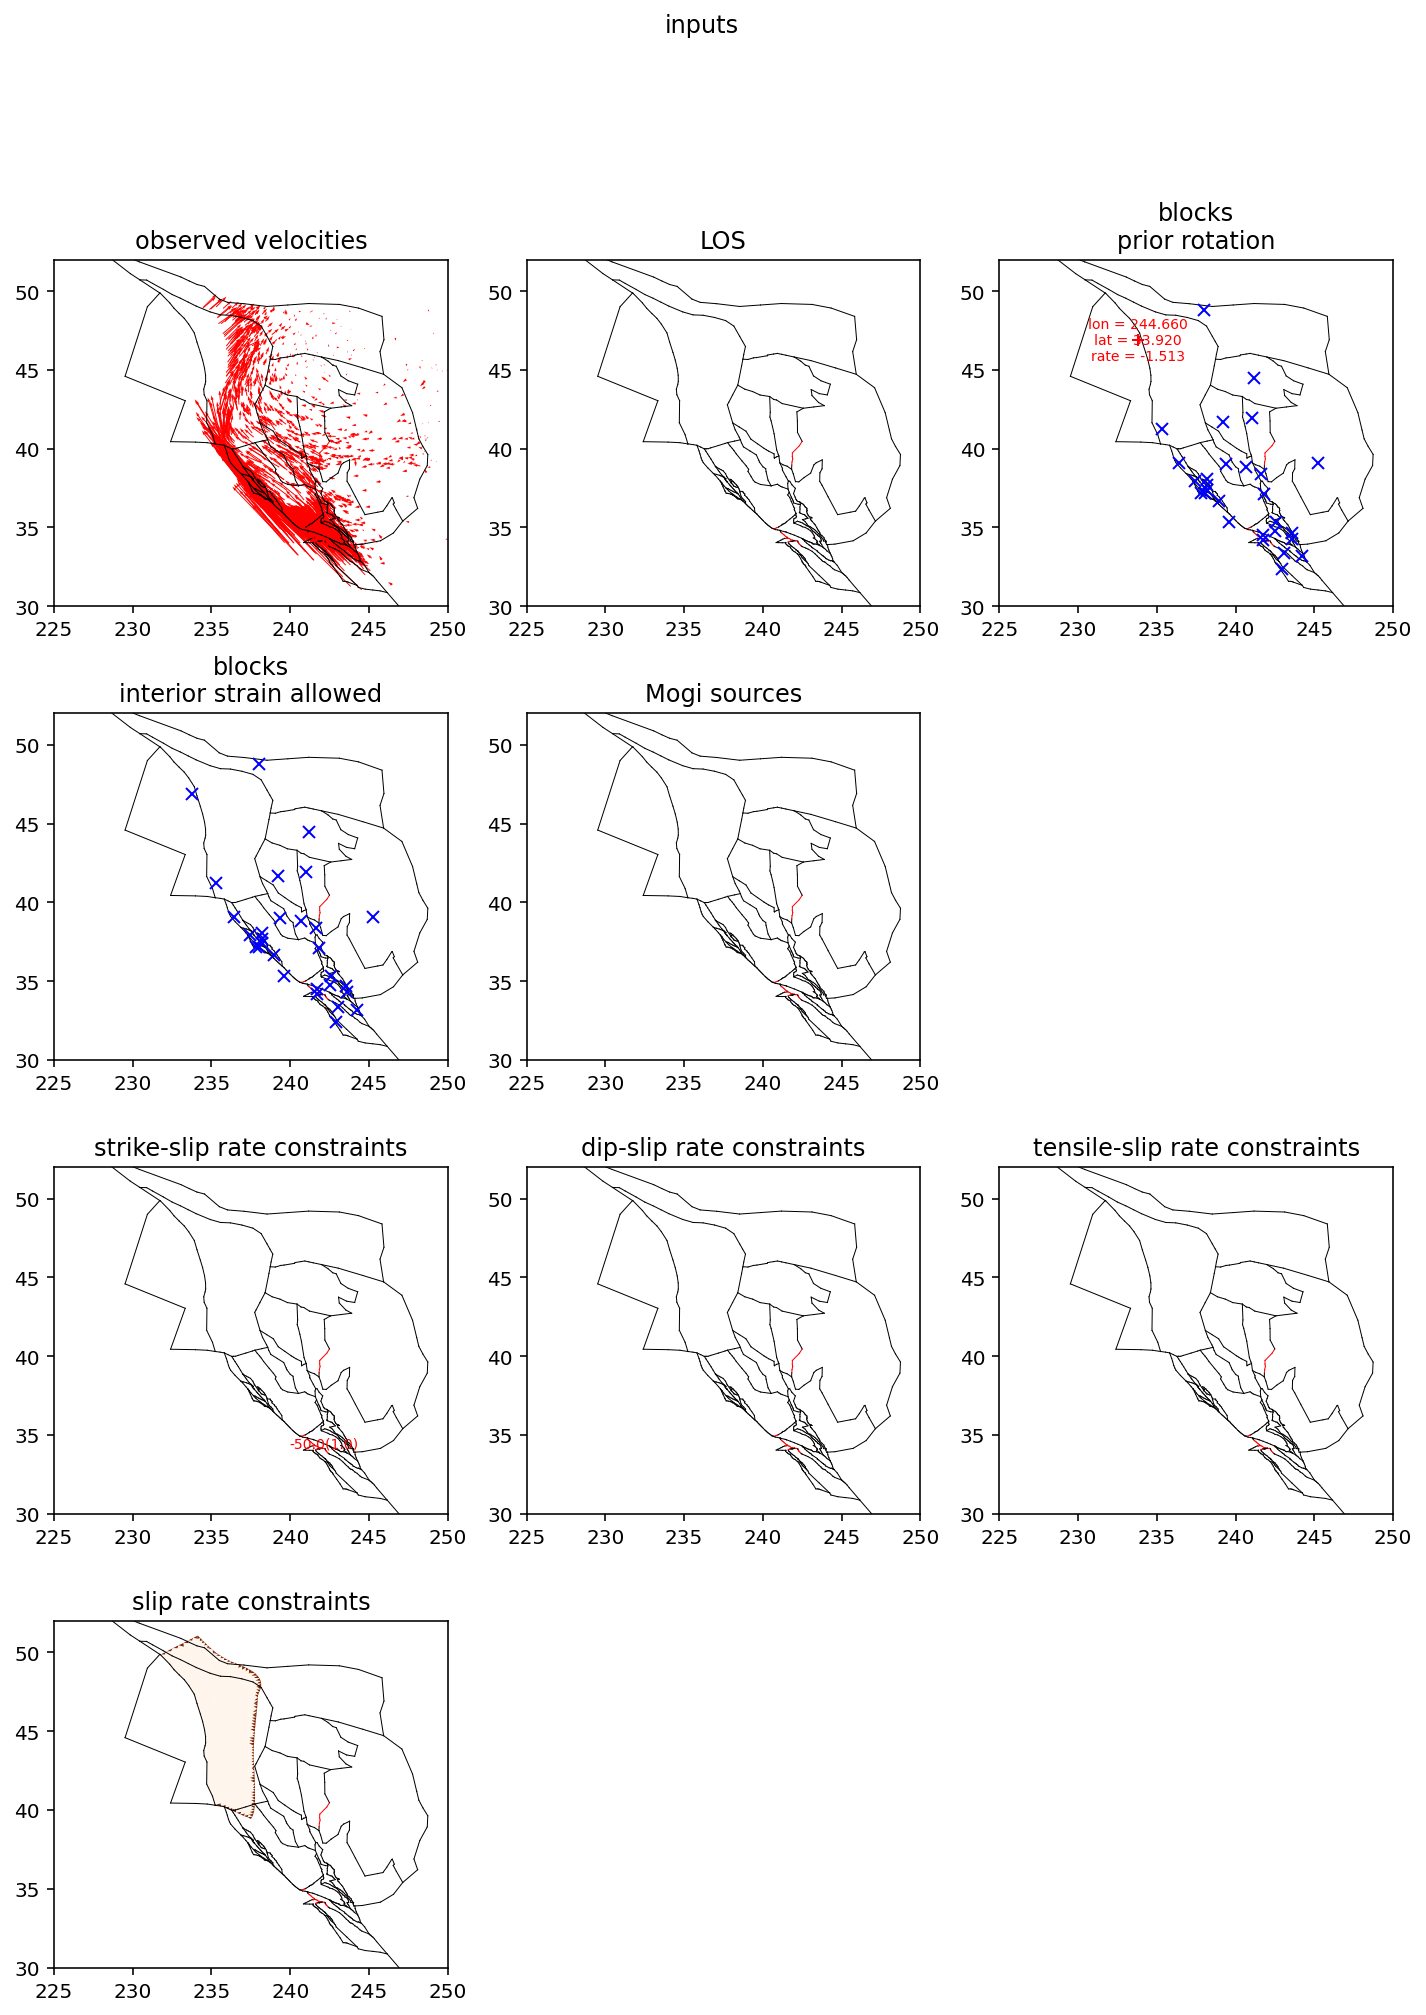

2023-02-20 23:04:08.324 | SUCCESS  | celeri.celeri:plot_input_summary:4044 - Wrote figures../runs/2023-02-20-23-04-03/plot_input_summary.(pdf, png)


<Figure size 432x288 with 0 Axes>

In [6]:
celeri.plot_input_summary(
    command,
    segment,
    station,
    block,
    meshes,
    mogi,
    sar,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=command.quiver_scale,
)

# Estimate block model parameters (dense)


In [7]:
index, estimation = celeri.assemble_and_solve_dense(
    command, assembly, operators, station, block, meshes
)
celeri.post_process_estimation(estimation, operators, station, index)
celeri.write_output(command, estimation, station, segment, block, meshes)

# Plot model summary


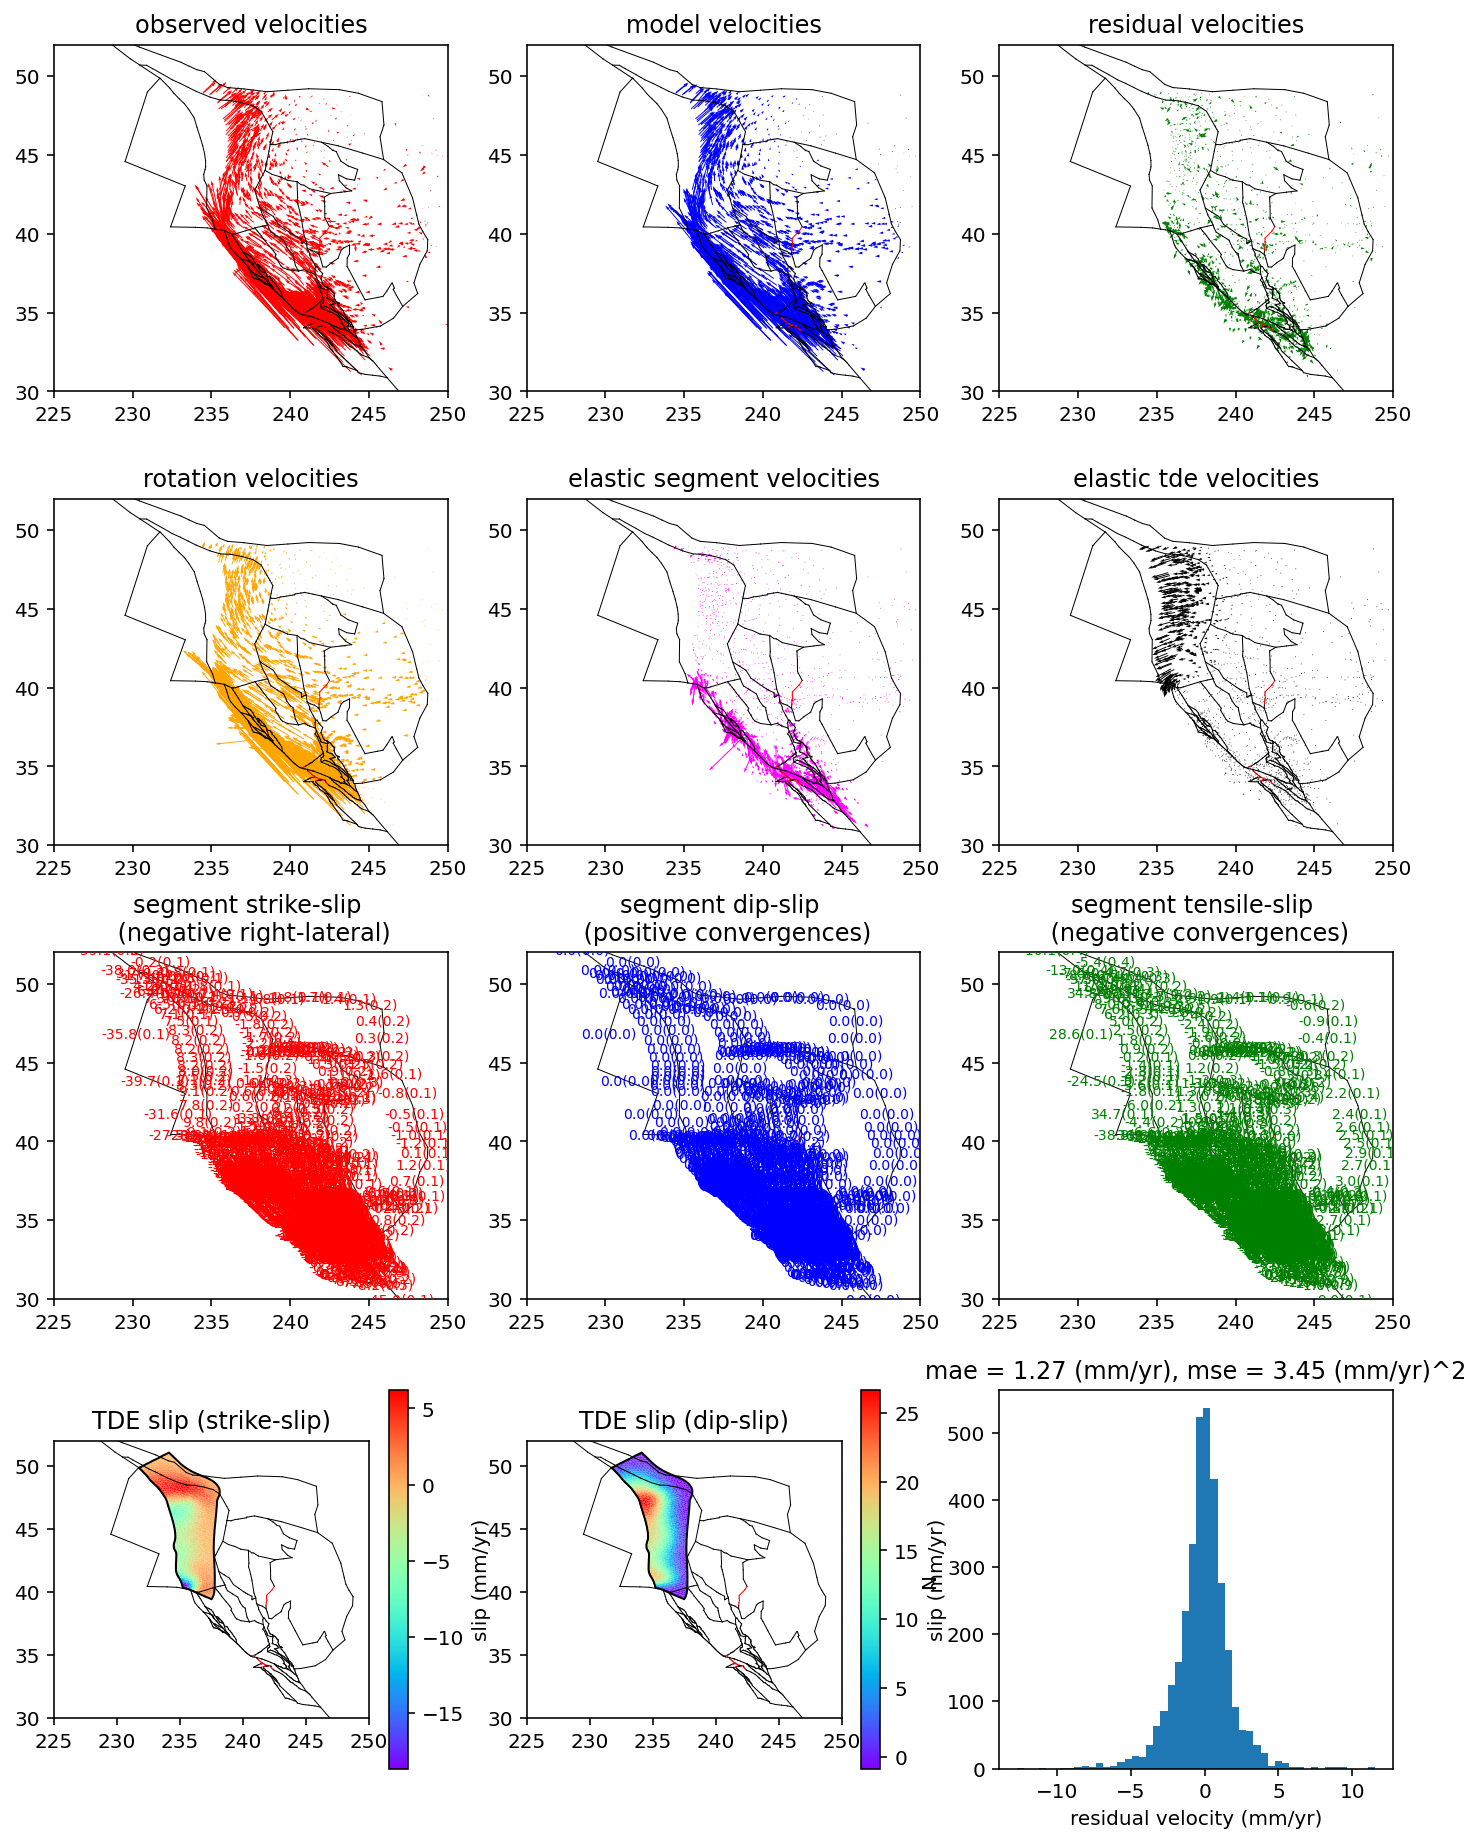

2023-02-20 23:04:18.569 | SUCCESS  | celeri.celeri:plot_estimation_summary:4544 - Wrote figures../runs/2023-02-20-23-04-03/plot_estimation_summary.(pdf, png)


<Figure size 432x288 with 0 Axes>

In [8]:
celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=command.quiver_scale,
)

# Standard plots

- Note that there are very few magic numbers here. The reason for this is that these values apply to almost all of the plots that follow so that by defining them up at the top we can make a single change and all figures are updated.


In [9]:
WORLD_BOUNDARIES = sio.loadmat("WorldHiVectors.mat")
FIGSIZE_VECTORS = (15, 8)
FONTSIZE = 16
LON_RANGE = (230, 250)
LAT_RANGE = (30, 52)
LON_TICKS = [230, 240, 250]
LAT_TICKS = [30, 41, 52]
SLIP_RATE_MIN = -25.0
SLIP_RATE_MAX = 25.0
LAND_COLOR = "lightgray"
LAND_LINEWIDTH = 0.5
LAND_ZORDER = 0
KEY_RECTANGLE_ANCHOR = [230, 30]
KEY_RECTANGLE_WIDTH = 5.0
KEY_RECTANGLE_HEIGHT = 2.0
KEY_ARROW_LON = 232.5
KEY_ARROW_LAT = 30.5
KEY_ARROW_MAGNITUDE = 25.0
KEY_ARROW_TEXT = "25 mm/yr"
KEY_ARROW_COLOR = "k"
KEY_BACKGROUND_COLOR = "white"
KEY_LINEWIDTH = 1.0
KEY_EDGECOLOR = "k"
ARROW_MAGNITUDE_MIN = 0.0
ARROW_MAGNITUDE_MAX = 25.0
ARROW_COLORMAP = cm.plasma
ARROW_SCALE = 100
ARROW_WIDTH = 0.0025
ARROW_LINEWIDTH = 0.5
ARROW_EDGECOLOR = "k"
SEGMENT_LINE_WIDTH_OUTER = 2.0
SEGMENT_LINE_WIDTH_INNER = 1.0
SEGMENT_LINE_COLOR_OUTER = "k"
SEGMENT_LINE_COLOR_INNER = "w"

In [10]:
def common_plot_elements(segment: pd.DataFrame, lon_range: Tuple, lat_range: Tuple):
    """Elements common to all subplots
    Args:
        segment (pd.DataFrame): Fault segments
        lon_range (Tuple): Longitude range (min, max)
        lat_range (Tuple): Latitude range (min, max)
    """
    for i in range(len(segment)):
        plt.plot(
            [segment.lon1[i], segment.lon2[i]],
            [segment.lat1[i], segment.lat2[i]],
            "-k",
            linewidth=SEGMENT_LINE_WIDTH_OUTER,
        )
    for i in range(len(segment)):
        plt.plot(
            [segment.lon1[i], segment.lon2[i]],
            [segment.lat1[i], segment.lat2[i]],
            "-w",
            linewidth=SEGMENT_LINE_WIDTH_INNER,
        )

    plt.xlim([lon_range[0], lon_range[1]])
    plt.ylim([lat_range[0], lat_range[1]])
    plt.xticks(LON_TICKS)
    plt.yticks(LAT_TICKS)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.xlabel("longitude (degrees)", fontsize=FONTSIZE)
    plt.ylabel("latitude (degrees)", fontsize=FONTSIZE)
    plt.tick_params(labelsize=FONTSIZE)


def plot_vel_arrows_elements(east_velocity, north_velocity, arrow_scale):
    # Draw velocity vectors
    velocity_magnitude = np.sqrt(east_velocity**2.0 + north_velocity**2.0)
    norm = Normalize()
    norm.autoscale(velocity_magnitude)
    norm.vmin = ARROW_MAGNITUDE_MIN
    norm.vmax = ARROW_MAGNITUDE_MAX
    colormap = ARROW_COLORMAP
    quiver_handle = plt.quiver(
        station.lon,
        station.lat,
        east_velocity,
        north_velocity,
        scale=ARROW_SCALE * arrow_scale,
        width=ARROW_WIDTH,
        scale_units="inches",
        color=colormap(norm(velocity_magnitude)),
        linewidth=ARROW_LINEWIDTH,
        edgecolor=ARROW_EDGECOLOR,
    )

    # Draw land
    plt.fill(
        WORLD_BOUNDARIES["lon"],
        WORLD_BOUNDARIES["lat"],
        color=LAND_COLOR,
        linewidth=LAND_LINEWIDTH,
        zorder=LAND_ZORDER,
    )

    # Draw white background rectangle
    rect = mpatches.Rectangle(
        KEY_RECTANGLE_ANCHOR,
        KEY_RECTANGLE_WIDTH,
        KEY_RECTANGLE_HEIGHT,
        fill=True,
        color=KEY_BACKGROUND_COLOR,
        linewidth=KEY_LINEWIDTH,
        ec=KEY_EDGECOLOR,
    )
    plt.gca().add_patch(rect)

    # # Draw arrow legend
    plt.quiverkey(
        quiver_handle,
        KEY_ARROW_LON,
        KEY_ARROW_LAT,
        KEY_ARROW_MAGNITUDE,
        KEY_ARROW_TEXT,
        coordinates="data",
        color=KEY_ARROW_COLOR,
        fontproperties={"size": FONTSIZE},
    )

    plt.gca().set_aspect("equal")
    plt.show()

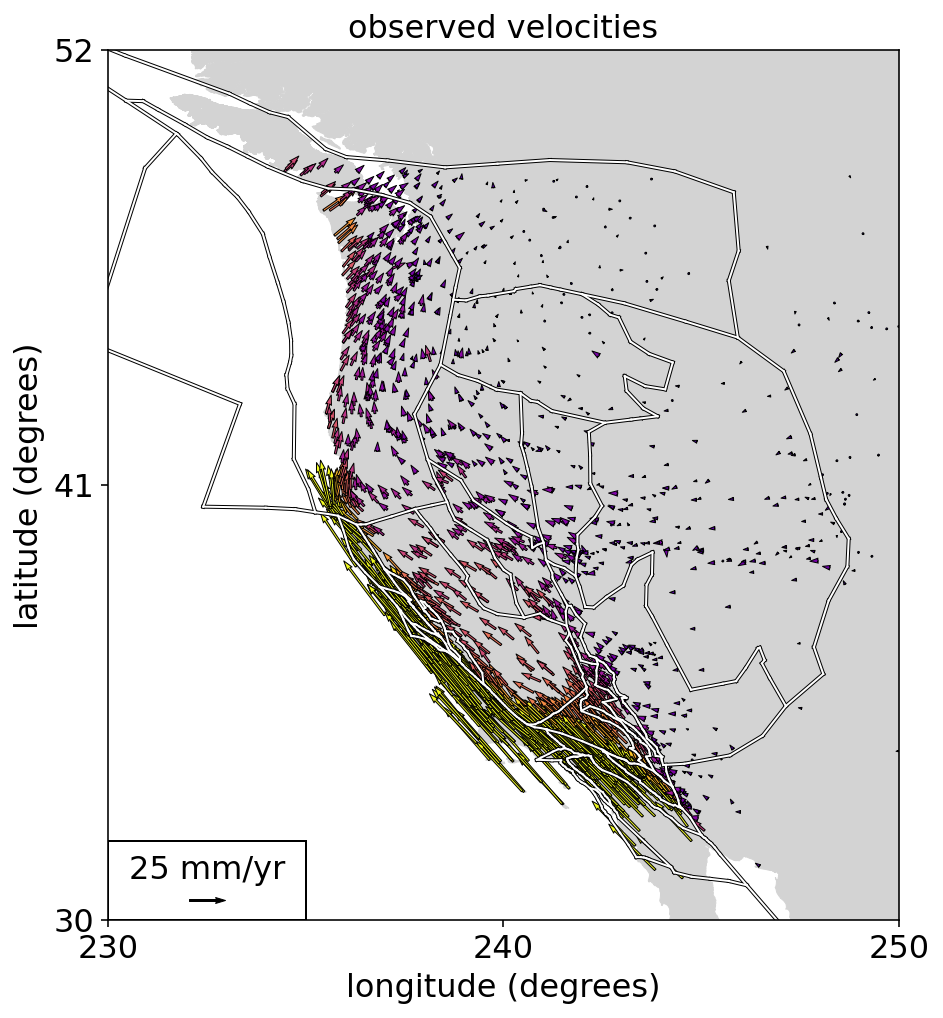

In [11]:
# Observed velocities
plt.figure(figsize=FIGSIZE_VECTORS)
plt.title("observed velocities", fontsize=FONTSIZE)
common_plot_elements(segment, LON_RANGE, LAT_RANGE)
plot_vel_arrows_elements(station.east_vel, station.north_vel, arrow_scale=1.0)

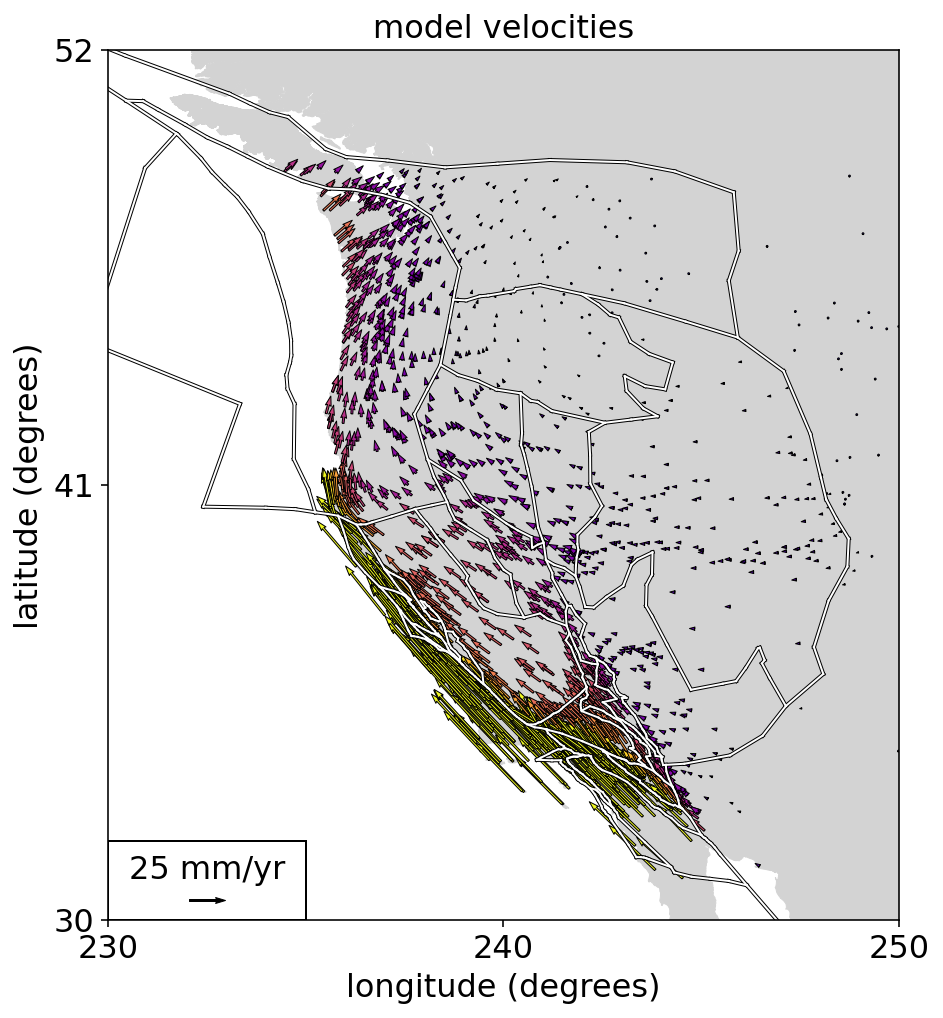

In [12]:
# Model velocities
plt.figure(figsize=FIGSIZE_VECTORS)
plt.title("model velocities", fontsize=FONTSIZE)
common_plot_elements(segment, LON_RANGE, LAT_RANGE)
plot_vel_arrows_elements(estimation.east_vel, estimation.north_vel, arrow_scale=1.0)

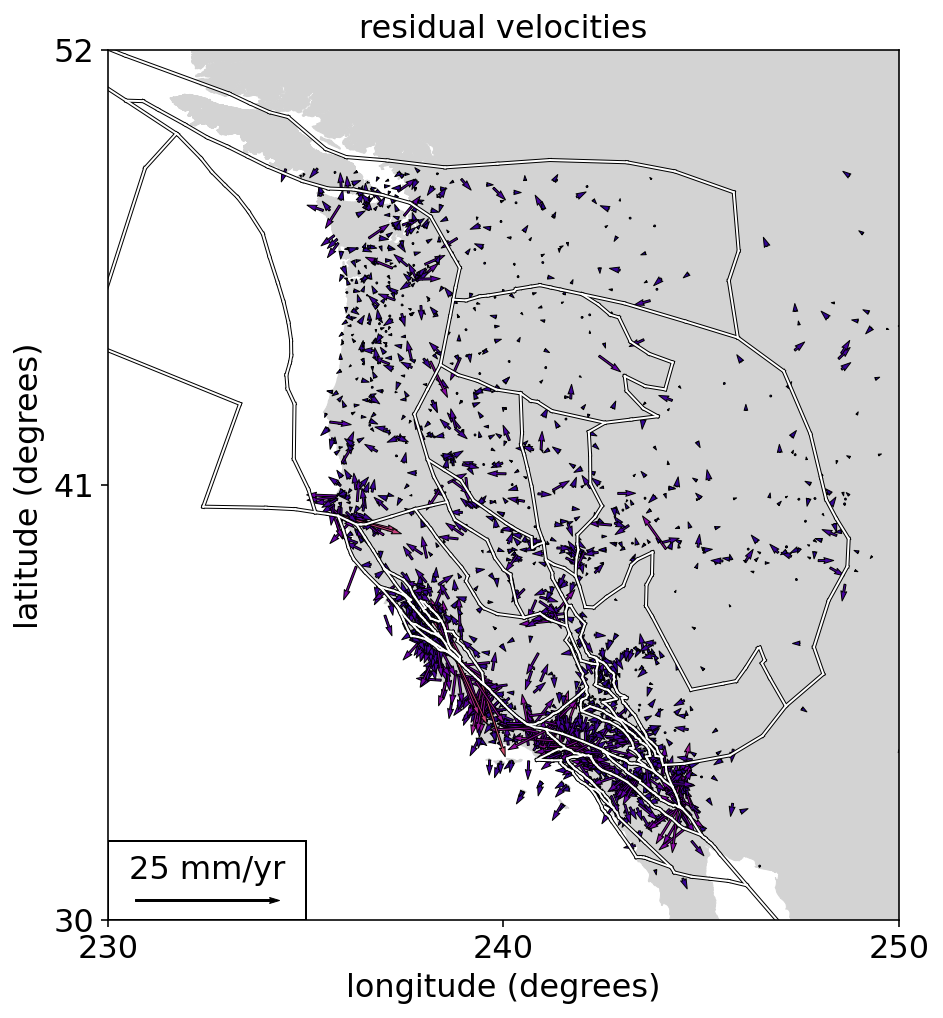

In [13]:
# Residual velocities
plt.figure(figsize=FIGSIZE_VECTORS)
plt.title("residual velocities", fontsize=FONTSIZE)
common_plot_elements(segment, LON_RANGE, LAT_RANGE)
plot_vel_arrows_elements(
    estimation.east_vel_residual, estimation.north_vel_residual, arrow_scale=0.25
)

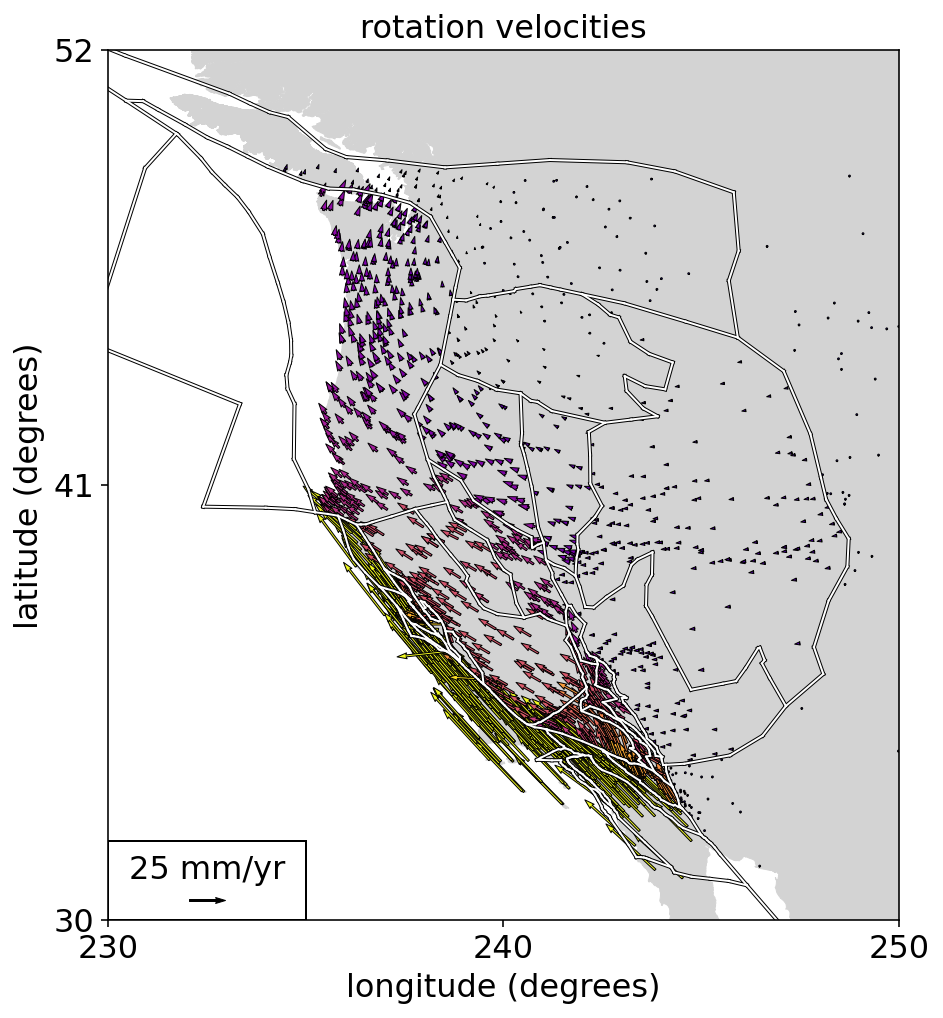

In [14]:
# Rotation velocities
plt.figure(figsize=FIGSIZE_VECTORS)
plt.title("rotation velocities", fontsize=FONTSIZE)
common_plot_elements(segment, LON_RANGE, LAT_RANGE)
plot_vel_arrows_elements(
    estimation.east_vel_rotation, estimation.north_vel_rotation, arrow_scale=1.0
)

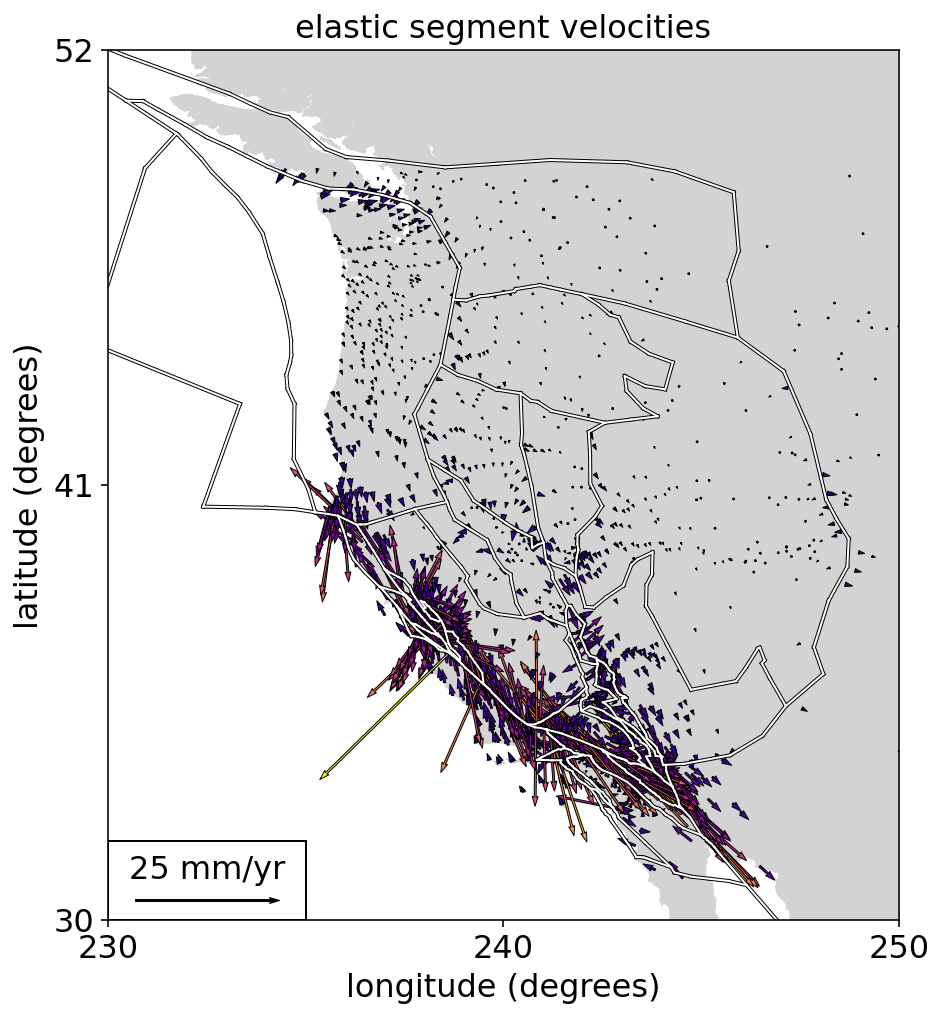

In [15]:
# Elastic segment velocities
plt.figure(figsize=FIGSIZE_VECTORS)
plt.title("elastic segment velocities", fontsize=FONTSIZE)
common_plot_elements(segment, LON_RANGE, LAT_RANGE)
plot_vel_arrows_elements(
    estimation.east_vel_elastic_segment,
    estimation.north_vel_elastic_segment,
    arrow_scale=0.25,
)

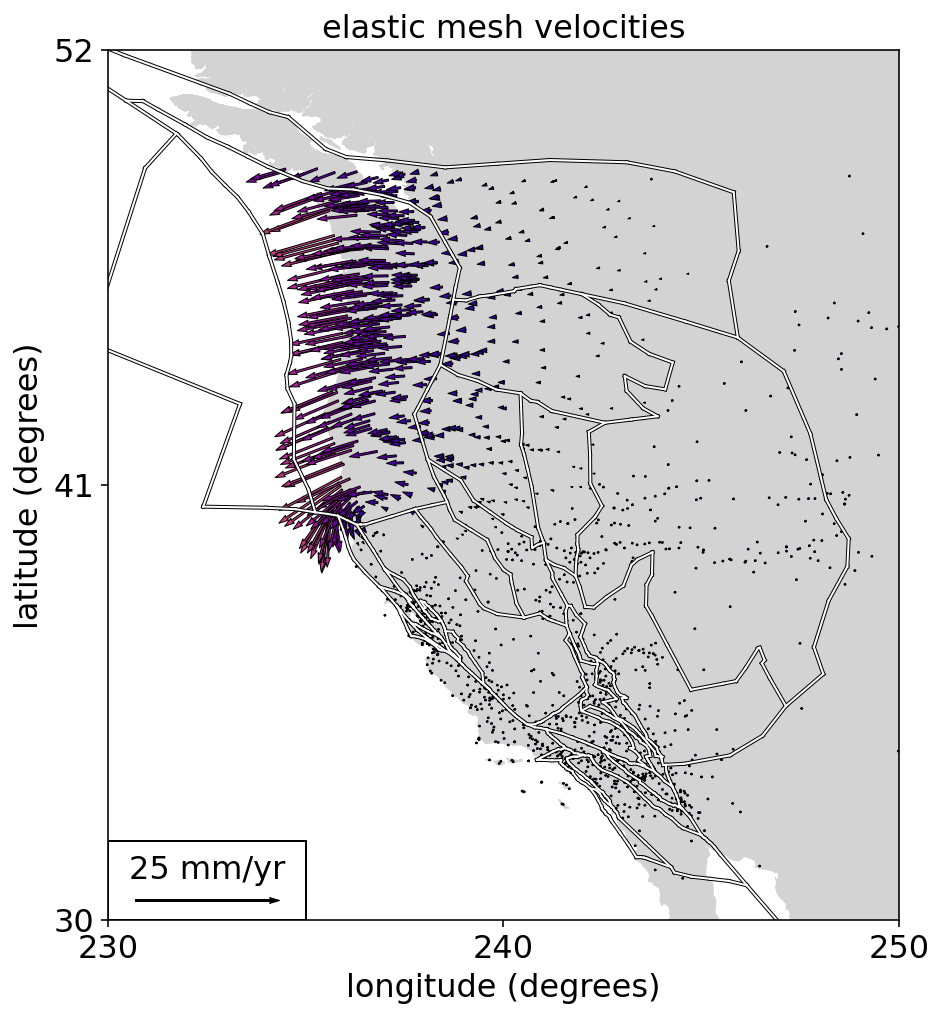

In [16]:
# Elastic tde velocities
plt.figure(figsize=FIGSIZE_VECTORS)
plt.title("elastic mesh velocities", fontsize=FONTSIZE)
common_plot_elements(segment, LON_RANGE, LAT_RANGE)
plot_vel_arrows_elements(
    estimation.east_vel_tde, estimation.north_vel_tde, arrow_scale=0.25
)

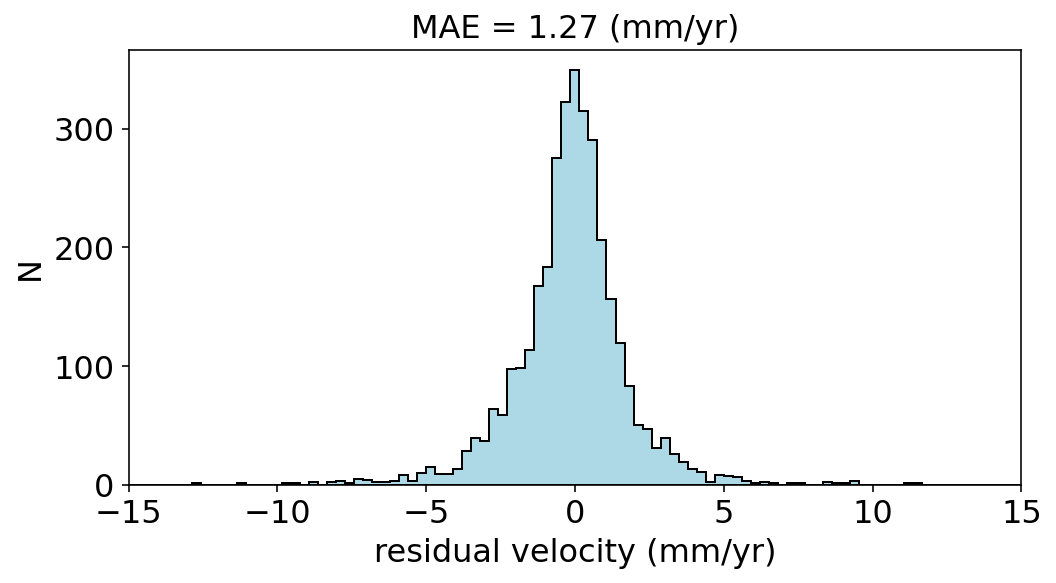

In [17]:
# Residual velocities
residual_velocity_vector = np.concatenate(
    (estimation.east_vel_residual.values, estimation.north_vel_residual.values)
)
mean_average_error = np.mean(np.abs(residual_velocity_vector))

N_BINS = 100
BIN_EDGE_MIN = -15
BIN_EDGE_MAX = 15
BINS = np.linspace(BIN_EDGE_MIN, BIN_EDGE_MAX, N_BINS)

# Create histogram of residual velocities
plt.figure(figsize=(8, 4))
plt.hist(
    residual_velocity_vector,
    BINS,
    histtype="stepfilled",
    color="lightblue",
    edgecolor="k",
)
plt.xlim([BIN_EDGE_MIN, BIN_EDGE_MAX])
plt.xlabel("residual velocity (mm/yr)", fontsize=FONTSIZE)
plt.ylabel("N", fontsize=FONTSIZE)
plt.title(f"MAE = {mean_average_error:.2f} (mm/yr)", fontsize=FONTSIZE)
plt.tick_params(labelsize=FONTSIZE)
plt.show()

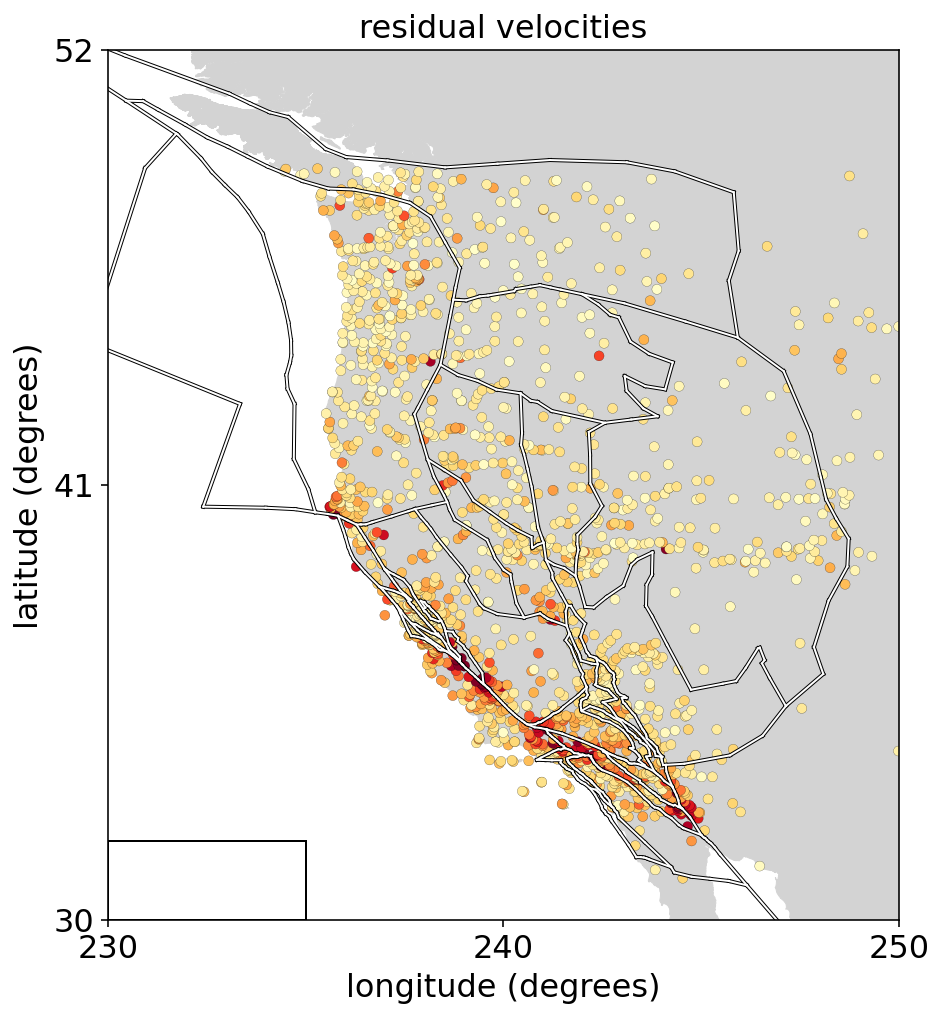

In [18]:
# Scatter plot for velocity estimate errors
mae_station = np.abs(estimation.east_vel_residual.values) + np.abs(
    estimation.north_vel_residual.values
)
fig = plt.figure(figsize=FIGSIZE_VECTORS)
plt.title("residual velocities", fontsize=16)
plt.fill(
    WORLD_BOUNDARIES["lon"],
    WORLD_BOUNDARIES["lat"],
    color=LAND_COLOR,
    linewidth=LAND_LINEWIDTH,
    zorder=LAND_ZORDER,
)

plt.scatter(
    station.lon,
    station.lat,
    s=25,
    edgecolors="k",
    c=mae_station,
    cmap="YlOrRd",
    linewidths=0.1,
)
common_plot_elements(segment, LON_RANGE, LAT_RANGE)

# cbar = plt.colorbar(label="absolute error", shrink=0.45)
plt.clim(0, 10)

# Draw white background rectangle
rect = mpatches.Rectangle(
    KEY_RECTANGLE_ANCHOR,
    KEY_RECTANGLE_WIDTH,
    KEY_RECTANGLE_HEIGHT,
    fill=True,
    color=KEY_BACKGROUND_COLOR,
    linewidth=KEY_LINEWIDTH,
    ec=KEY_EDGECOLOR,
)
plt.gca().add_patch(rect)
plt.show()

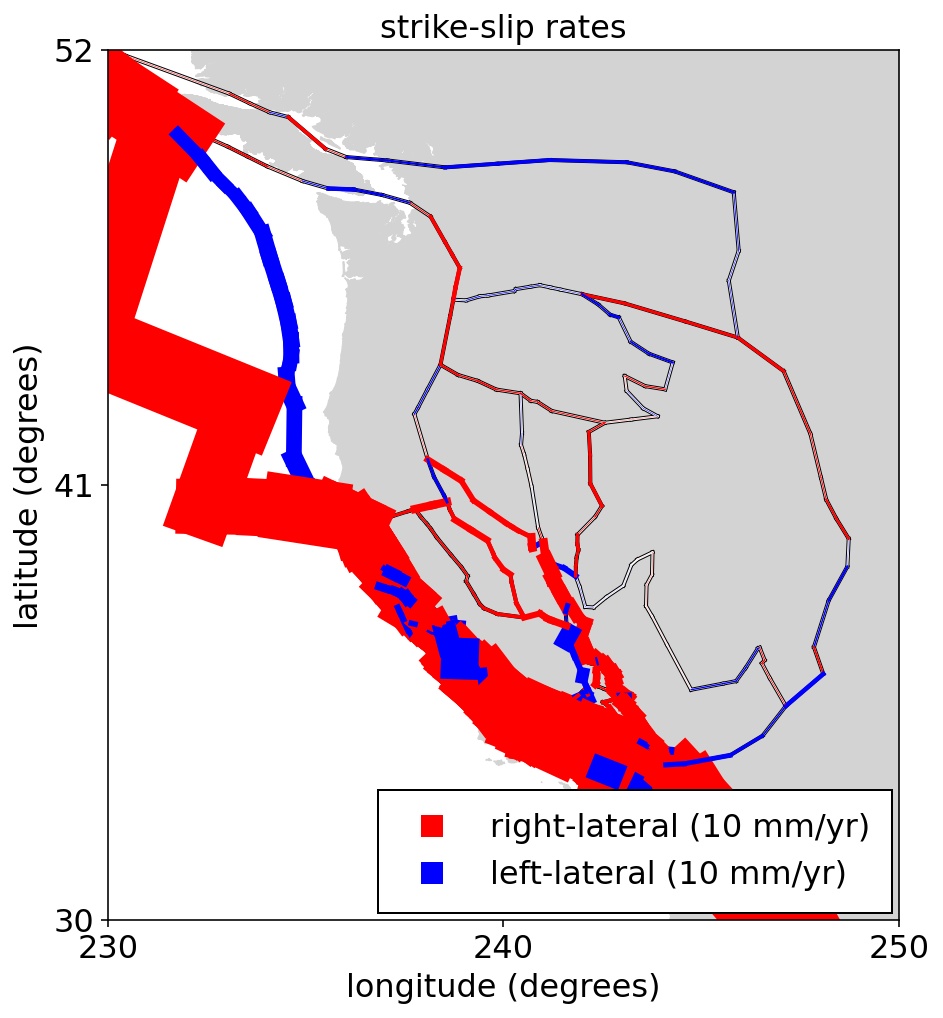

In [19]:
# Plot estimated strike-slip rates
plt.figure(figsize=FIGSIZE_VECTORS)
plt.title("strike-slip rates", fontsize=FONTSIZE)
common_plot_elements(segment, LON_RANGE, LAT_RANGE)

plt.fill(
    WORLD_BOUNDARIES["lon"],
    WORLD_BOUNDARIES["lat"],
    color=LAND_COLOR,
    linewidth=LAND_LINEWIDTH,
    zorder=LAND_ZORDER,
)

for i in range(len(segment)):
    if estimation.strike_slip_rates[i] < 0:
        plt.plot(
            [segment.lon1[i], segment.lon2[i]],
            [segment.lat1[i], segment.lat2[i]],
            "-r",
            linewidth=estimation.strike_slip_rates[i],
        )
    else:
        plt.plot(
            [segment.lon1[i], segment.lon2[i]],
            [segment.lat1[i], segment.lat2[i]],
            "-b",
            linewidth=estimation.strike_slip_rates[i],
        )

# Legend
black_segments = mlines.Line2D(
    [],
    [],
    color="red",
    marker="s",
    linestyle="None",
    markersize=10,
    label="right-lateral (10 mm/yr)",
)
red_segments = mlines.Line2D(
    [],
    [],
    color="blue",
    marker="s",
    linestyle="None",
    markersize=10,
    label="left-lateral (10 mm/yr)",
)
plt.legend(
    handles=[black_segments, red_segments],
    loc="lower right",
    fontsize=FONTSIZE,
    framealpha=1.0,
    edgecolor="k",
).get_frame().set_boxstyle("Square")

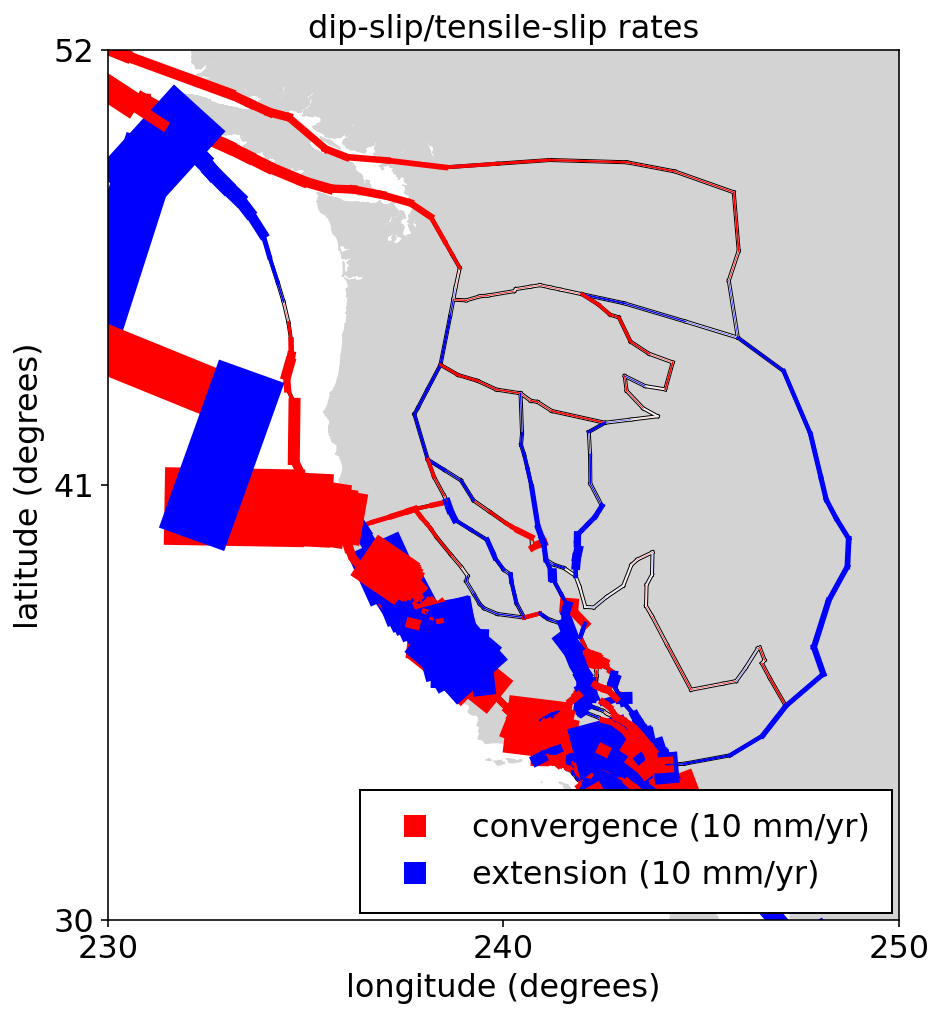

In [20]:
# Plot estimated strike-slip rates
plt.figure(figsize=FIGSIZE_VECTORS)
plt.title("dip-slip/tensile-slip rates", fontsize=FONTSIZE)
common_plot_elements(segment, LON_RANGE, LAT_RANGE)

plt.fill(
    WORLD_BOUNDARIES["lon"],
    WORLD_BOUNDARIES["lat"],
    color=LAND_COLOR,
    linewidth=LAND_LINEWIDTH,
    zorder=LAND_ZORDER,
)

for i in range(len(segment)):
    if estimation.dip_slip_rates[i] > 0:
        plt.plot(
            [segment.lon1[i], segment.lon2[i]],
            [segment.lat1[i], segment.lat2[i]],
            "-r",
            linewidth=estimation.dip_slip_rates[i],
        )
    else:
        plt.plot(
            [segment.lon1[i], segment.lon2[i]],
            [segment.lat1[i], segment.lat2[i]],
            "-b",
            linewidth=estimation.dip_slip_rates[i],
        )

for i in range(len(segment)):
    if estimation.tensile_slip_rates[i] < 0:
        plt.plot(
            [segment.lon1[i], segment.lon2[i]],
            [segment.lat1[i], segment.lat2[i]],
            "-r",
            linewidth=estimation.tensile_slip_rates[i],
        )
    else:
        plt.plot(
            [segment.lon1[i], segment.lon2[i]],
            [segment.lat1[i], segment.lat2[i]],
            "-b",
            linewidth=estimation.tensile_slip_rates[i],
        )


# Legend
black_segments = mlines.Line2D(
    [],
    [],
    color="red",
    marker="s",
    linestyle="None",
    markersize=10,
    label="convergence (10 mm/yr)",
)
red_segments = mlines.Line2D(
    [],
    [],
    color="blue",
    marker="s",
    linestyle="None",
    markersize=10,
    label="extension (10 mm/yr)",
)
plt.legend(
    handles=[black_segments, red_segments],
    loc="lower right",
    fontsize=FONTSIZE,
    framealpha=1.0,
    edgecolor="k",
).get_frame().set_boxstyle("Square")

# Start of KL approach

n_eigenvalues=20
meshes[0].n_tde=1841
i=0
i=1
i=2
i=3
i=4
i=5
i=6
i=7
i=8
i=9


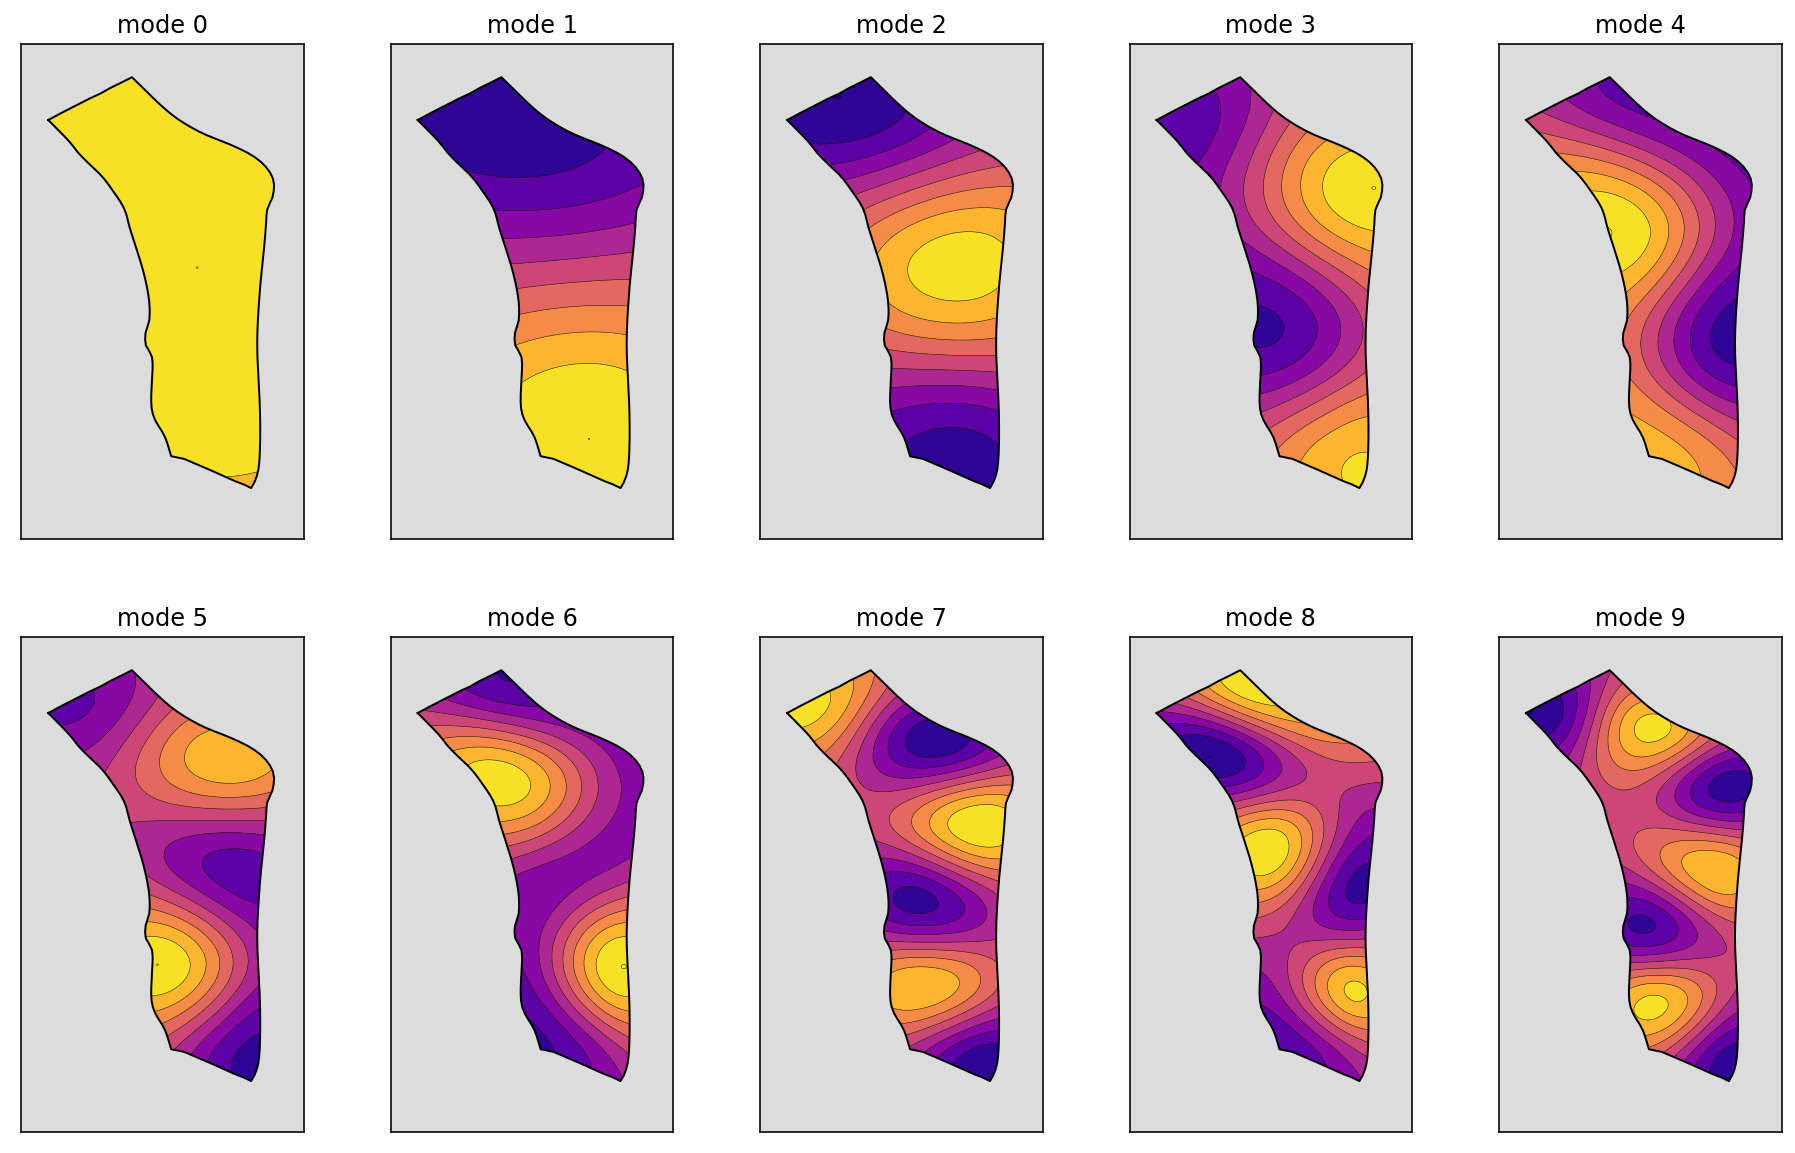

In [23]:
import scipy
import warnings

N_CONTOUR_LEVELS = 10


def inpolygon(xq, yq, xv, yv):
    shape = xq.shape
    xq = xq.reshape(-1)
    yq = yq.reshape(-1)
    xv = xv.reshape(-1)
    yv = yv.reshape(-1)
    q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
    p = matplotlib.path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
    return p.contains_points(q).reshape(shape)


def rbf_interpolate(fill_value):
    # Observation coordinates and data
    x_vec = np.linspace(231, 239, N_GRID_X)
    y_vec = np.linspace(38, 52, N_GRID_Y)
    x_mat, y_mat = np.meshgrid(x_vec, y_vec)
    y_mat = y_mat
    centroids_lon = meshes[0].centroids[:, 0]
    centroids_lat = meshes[0].centroids[:, 1]
    centroids_val = fill_value

    # Package for RBFInterpolator
    xgrid = np.stack((x_mat, y_mat))
    xflat = xgrid.reshape(2, -1).T
    xobs = np.vstack((centroids_lon, centroids_lat)).T
    yobs = centroids_val
    yflat = scipy.interpolate.RBFInterpolator(
        xobs, yobs, kernel="cubic", smoothing=0.01, epsilon=1.5
    )(xflat)
    ygrid = yflat.reshape(N_GRID_X, N_GRID_Y)
    return xgrid, ygrid


def get_eigenvalues_and_eigenvectors(n_eigenvalues, x, y, z):
    n_tde = x.size

    # Calculate Cartesian distances between triangle centroids
    centroid_coordinates = np.array([x, y, z]).T
    distance_matrix = scipy.spatial.distance.cdist(
        centroid_coordinates, centroid_coordinates, "euclidean"
    )

    # Rescale distance matrix to the range 0-1
    distance_matrix = (distance_matrix - np.min(distance_matrix)) / np.ptp(
        distance_matrix
    )

    # Calculate correlation matrix
    correlation_matrix = np.exp(-distance_matrix)

    # https://stackoverflow.com/questions/12167654/fastest-way-to-compute-k-largest-eigenvalues-and-corresponding-eigenvectors-with
    eigenvalues, eigenvectors = scipy.linalg.eigh(
        correlation_matrix,
        subset_by_index=[n_tde - n_eigenvalues, n_tde - 1],
    )
    eigenvalues = np.real(eigenvalues)
    eigenvectors = np.real(eigenvectors)
    ordered_index = np.flip(np.argsort(eigenvalues))
    eigenvalues = eigenvalues[ordered_index]
    eigenvectors = eigenvectors[:, ordered_index]
    return eigenvalues, eigenvectors


# Visualize eigenvectors
def interpolate_and_plot(fill_value):
    # Interpolate values onto a regular grid for plotting
    # If the fill value has very little variation so it can be contoured
    if fill_value.ptp() < 1e-4:
        fill_value = 1e-4 * np.ones_like(fill_value)

    xgrid, ygrid = rbf_interpolate(fill_value)
    xflat = xgrid.reshape(2, -1).T
    inpolygon_vals = inpolygon(
        xflat[:, 0], xflat[:, 1], meshes[0].x_perimeter, meshes[0].y_perimeter
    )
    inpolygon_vals = np.reshape(inpolygon_vals, (N_GRID_X, N_GRID_Y))
    ygrid[~inpolygon_vals] = np.nan

    # Plot
    levels = np.linspace(-1.0, 1.0, N_CONTOUR_LEVELS)
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore", message="No contour levels were found within the data range."
        )
        plt.contourf(*xgrid, ygrid, cmap=cmap, levels=levels, extend="both")
        plt.contour(
            *xgrid,
            ygrid,
            colors="k",
            linestyles="solid",
            linewidths=0.25,
            levels=levels,
        )
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.xticks([])
    plt.yticks([])


# Calculate eigenvales and eigenvectors for triangle subset
n_eigenvalues = meshes[0].n_tde
n_eigenvalues = 20


eigenvalues, eigenvectors = get_eigenvalues_and_eigenvectors(
    n_eigenvalues,
    meshes[0].x_centroid,
    meshes[0].y_centroid,
    meshes[0].z_centroid,
)
print(f"{n_eigenvalues=}")
print(f"{meshes[0].n_tde=}")

# Plot eigenmodes
N_GRID_X = 500
N_GRID_Y = 500

# Plot select eigenmodes
cmap = "plasma"
plt.figure(figsize=(16, 10))
for i in range(0, 10):
    print(f"{i=}")
    ax = plt.subplot(2, 5, i + 1)
    # if i >= 6:
    #     i = i + 50 - 6

    fill_value = eigenvectors[:, i]

    # Normalize fill_value for interpretable plotting
    min_value = np.min(fill_value)
    max_value = np.max(fill_value)
    if np.abs(max_value) > np.abs(min_value):
        fill_value = fill_value / max_value
    else:
        fill_value = fill_value / np.abs(min_value)

    if i == 0 and np.nanmean(fill_value) < 0:
        fill_value = -1 * fill_value

    interpolate_and_plot(fill_value)
    plt.gca().set_facecolor("gainsboro")
    plt.title(f"mode {i}")

plt.show()

# Build Eigenvector to fault slip (checkerboard style matrix):
# See: [celeri_eigenmodes_boundary_condition_experiments.ipynb] for reference


eigenvectors_two_component.shape=(3682, 40)


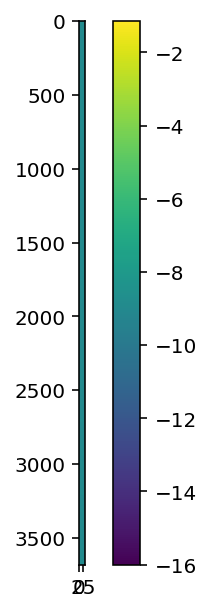

In [24]:
# Create modified eigenvector matrix here
# This is a replication of the EVs for both slip components
# There are other ways to do this but as implemented is a sort of
# checkerboard like pattern.  The column indexing an every other
# row striding implements this.
eigenvectors_two_component = np.zeros(
    (2 * eigenvectors.shape[0], 2 * eigenvectors.shape[1])
)
for i in range(n_eigenvalues):
    index_column_1 = 2 * i
    index_column_2 = 2 * i + 1
    eigenvectors_two_component[0::2, index_column_1] = eigenvectors[:, i]
    eigenvectors_two_component[1::2, index_column_2] = eigenvectors[:, i]

print(f"{eigenvectors_two_component.shape=}")

eigenvectors_two_component += 1e-16
plt.figure(figsize=(5, 5))
plt.imshow(np.log10(np.abs(eigenvectors_two_component)))
plt.colorbar()
plt.show()

# Assemble linear system for KL case

In [37]:
DEG_PER_MYR_TO_RAD_PER_YR = 1 / 1e6  # TODO: What should this conversion be?


def get_data_vector_eigen(assembly, index):
    data_vector = np.zeros(
        2 * index.n_stations
        + 3 * index.n_block_constraints
        + index.n_slip_rate_constraints
        + index.n_tde_constraints_total
    )

    # Add GPS stations to data vector
    data_vector[index.start_station_row : index.end_station_row] = celeri.interleave2(
        assembly.data.east_vel, assembly.data.north_vel
    )

    # Add block motion constraints to data vector
    data_vector[index.start_block_constraints_row : index.end_block_constraints_row] = (
        DEG_PER_MYR_TO_RAD_PER_YR * assembly.data.block_constraints
    )

    # Add slip rate constraints to data vector
    data_vector[
        index.start_slip_rate_constraints_row : index.end_slip_rate_constraints_row
    ] = assembly.data.slip_rate_constraints
    return data_vector


def get_weighting_vector_eigen(command, station, meshes, index):
    # Initialize and build weighting matrix
    weighting_vector = np.ones(
        2 * index.n_stations
        + 3 * index.n_block_constraints
        + index.n_slip_rate_constraints
        + index.n_tde_constraints_total
    )

    weighting_vector[
        index.start_station_row : index.end_station_row
    ] = celeri.interleave2(1 / (station.east_sig**2), 1 / (station.north_sig**2))

    weighting_vector[
        index.start_block_constraints_row : index.end_block_constraints_row
    ] = command.block_constraint_weight

    weighting_vector[
        index.start_slip_rate_constraints_row : index.end_slip_rate_constraints_row
    ] = command.slip_constraint_weight * np.ones(index.n_slip_rate_constraints)

    for i in range(len(meshes)):
        # TODO: This is too hacky to keep.  Revise with no reference to smoothing
        weighting_vector[
            index.start_tde_smoothing_row[i] : index.start_tde_smoothing_row[i]
            + index.n_tde_constraints[i]
        ] = command.tri_con_weight * np.ones(index.n_tde_constraints[i])

    return weighting_vector


def get_full_dense_operator_eigen(operators, meshes, index):
    # Initialize linear operator

    n_eigen = eigenvectors_two_component.shape[1] / 2
    print(f"{n_eigen=}")

    operator = np.zeros(
        (
            2 * index.n_stations
            + 3 * index.n_block_constraints
            + index.n_slip_rate_constraints
            # + 2 * index.n_tde_total
            + index.n_tde_constraints_total,
            3 * index.n_blocks + 2 * int(n_eigen),
        )
    )
    print(f"{eigenvectors_two_component.shape=}")
    print(f"{operator.shape=}")

    # Insert block rotations and elastic velocities from fully locked segments
    operators.rotation_to_slip_rate_to_okada_to_velocities = (
        operators.slip_rate_to_okada_to_velocities @ operators.rotation_to_slip_rate
    )
    operator[
        index.start_station_row : index.end_station_row,
        index.start_block_col : index.end_block_col,
    ] = (
        operators.rotation_to_velocities[index.station_row_keep_index, :]
        - operators.rotation_to_slip_rate_to_okada_to_velocities[
            index.station_row_keep_index, :
        ]
    )

    # Insert block motion constraints
    operator[
        index.start_block_constraints_row : index.end_block_constraints_row,
        index.start_block_col : index.end_block_col,
    ] = operators.block_motion_constraints

    # Insert slip rate constraints
    operator[
        index.start_slip_rate_constraints_row : index.end_slip_rate_constraints_row,
        index.start_block_col : index.end_block_col,
    ] = operators.slip_rate_constraints

    # Insert eigenvector to velocity matrix
    tde_keep_row_index = celeri.get_keep_index_12(
        operators.tde_to_velocities[0].shape[0]
    )
    tde_keep_col_index = celeri.get_keep_index_12(
        operators.tde_to_velocities[0].shape[1]
    )
    eigen_to_velocities = (
        -operators.tde_to_velocities[0][tde_keep_row_index, :][:, tde_keep_col_index]
        @ eigenvectors_two_component
    )
    operator[
        index.start_station_row : index.end_station_row,
        index.start_tde_col[0] : index.start_tde_col[0] + 2 * n_eigenvalues,
    ] = eigen_to_velocities

    # Insert eigenvector to TDE constraints matrix
    NNN = 1e1
    eigen_to_tde_slip_rate_constraints = (
        NNN * operators.tde_slip_rate_constraints[0] @ eigenvectors_two_component
    )

    operator[
        index.start_slip_rate_constraints_row : index.start_slip_rate_constraints_row
        + index.n_tde_constraints_total,
        index.start_tde_col[0] : index.start_tde_col[0] + 2 * n_eigenvalues,
    ] = eigen_to_tde_slip_rate_constraints

    # # Insert TDE to velocity matrix
    # for i in range(len(meshes)):
    #     # Insert TDE to velocity matrix
    #     tde_keep_row_index = celeri.get_keep_index_12(operators.tde_to_velocities[i].shape[0])
    #     tde_keep_col_index = celeri.get_keep_index_12(operators.tde_to_velocities[i].shape[1])
    #     operator[
    #         index.start_station_row : index.end_station_row,
    #         index.start_tde_col[i] : index.end_tde_col[i],
    #     ] = -operators.tde_to_velocities[i][tde_keep_row_index, :][
    #         :, tde_keep_col_index
    #     ]

    #     # # Insert TDE smoothing matrix
    #     # smoothing_keep_index = celeri.get_keep_index_12(
    #     #     operators.tde_to_velocities[i].shape[1]
    #     # )
    #     # operator[
    #     #     index.start_tde_smoothing_row[i] : index.end_tde_smoothing_row[i],
    #     #     index.start_tde_col[i] : index.end_tde_col[i],
    #     # ] = operators.smoothing_matrix[i].toarray()[smoothing_keep_index, :][
    #     #     :, smoothing_keep_index
    #     # ]

    #     # Insert TDE slip rate constraints into estimation operator
    #     operator[
    #         index.start_tde_constraint_row[i] : index.end_tde_constraint_row[i],
    #         index.start_tde_col[i] : index.end_tde_col[i],
    #     ] = operators.tde_slip_rate_constraints[i]
    return operator


data_vector = celeri.get_data_vector(assembly, index)
data_vector_eigen = get_data_vector_eigen(assembly, index)
weighting_vector = celeri.get_weighting_vector(command, station, meshes, index)
weighting_vector_eigen = get_weighting_vector_eigen(command, station, meshes, index)
operator = celeri.get_full_dense_operator(operators, meshes, index)
operator_eigen = get_full_dense_operator_eigen(operators, meshes, index)


# What shape should operator be?
#
# n_cols = 3 * n_blocks + 2 * n_eigen
# n_cols = 3 * 31 + 2 * 100
# n_cols = 293
#
# n_rows = 2 * n_stations + 3 * n_block_constraints + n_slip_rate_constraints + n_tde_constraints_total
# n_rows = 2 * 1686 + 3 * 1 + 1 + 172
# n_rows = 3548

n_eigen=20.0
eigenvectors_two_component.shape=(3682, 40)
operator.shape=(3548, 133)


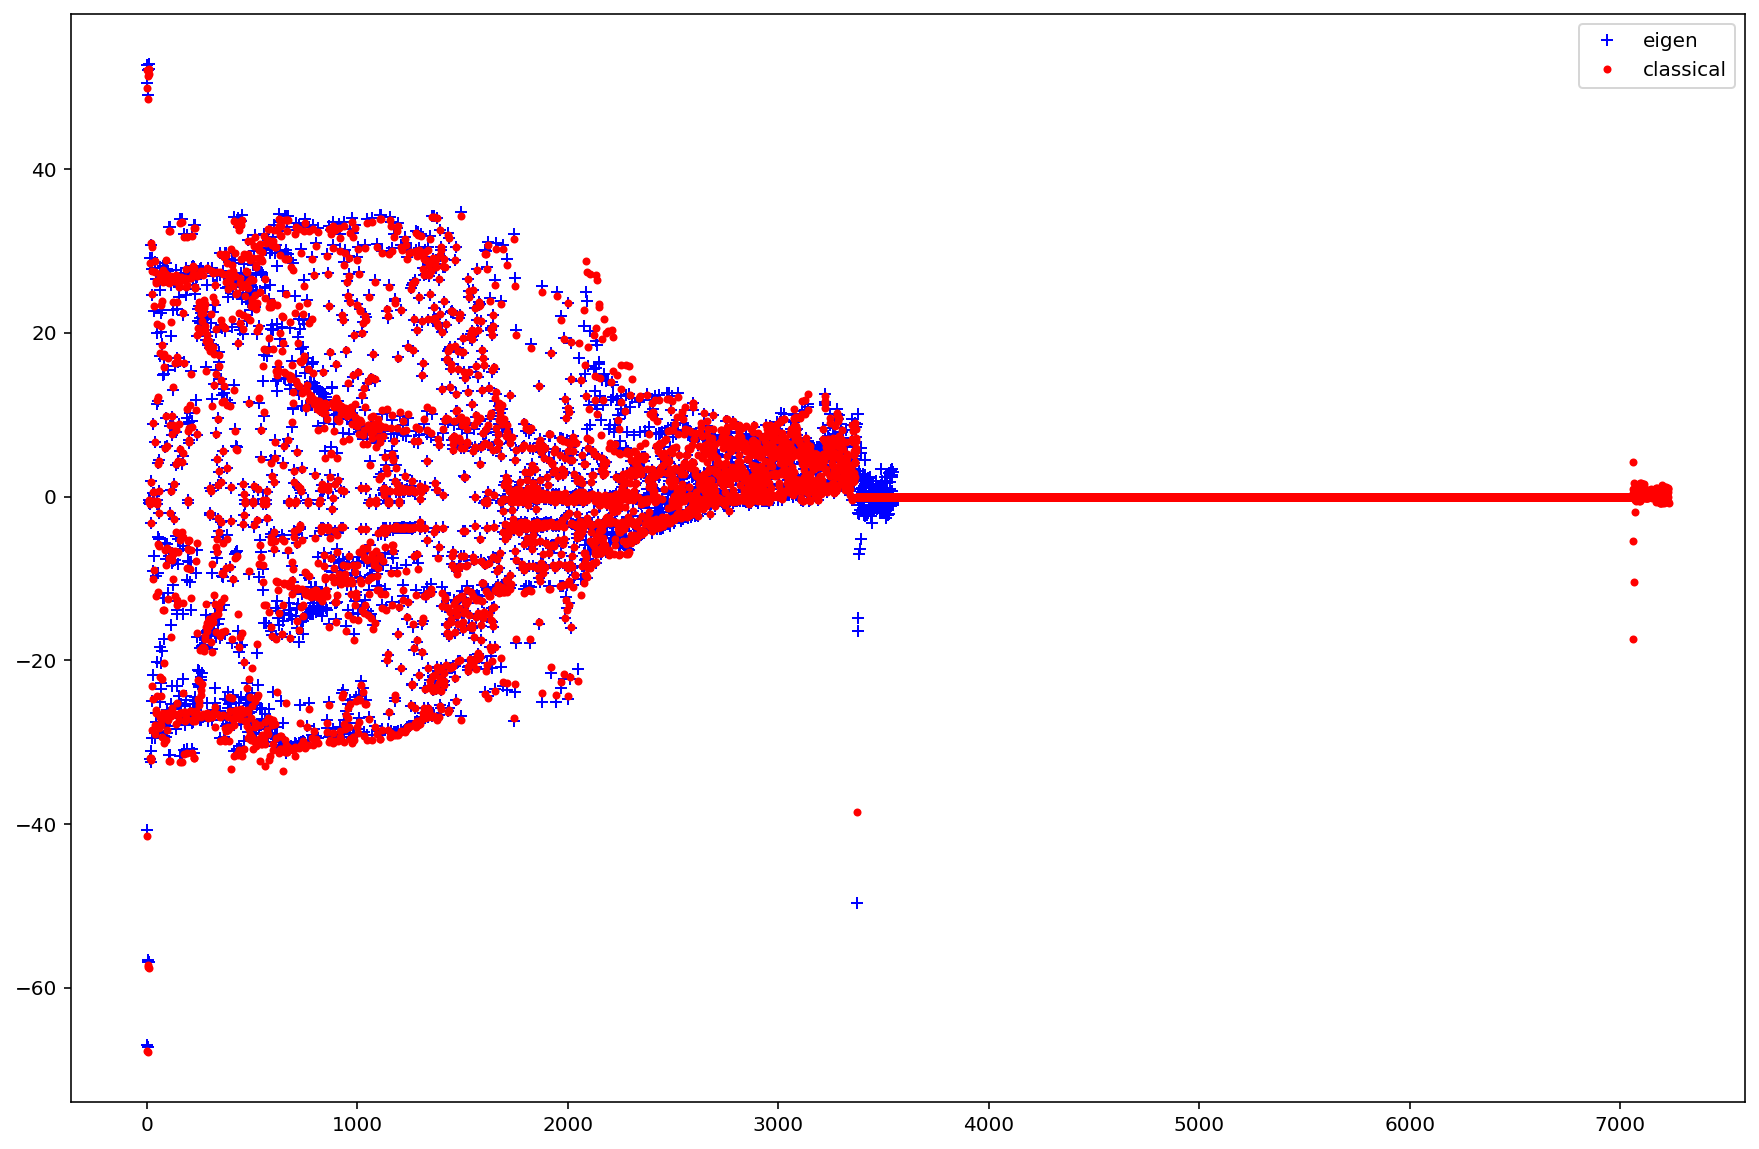

In [38]:
def post_process_estimation_eigen(
    estimation_eigen: Dict, operators: Dict, station: pd.DataFrame, index: Dict
):
    """Calculate derived values derived from the block model linear estimate (e.g., velocities, undertainties)

    Args:
        estimation (Dict): Estimated state vector and model covariance
        operators (Dict): All linear operators
        station (pd.DataFrame): GPS station data
        idx (Dict): Indices and counts of data and array sizes
    """

    # TODO: Start working through this for the EV case
    estimation_eigen.predictions = (
        estimation_eigen.operator @ estimation_eigen.state_vector
    )
    estimation_eigen.vel = estimation_eigen.predictions[0 : 2 * index.n_stations]
    estimation_eigen.east_vel = estimation_eigen.vel[0::2]
    estimation_eigen.north_vel = estimation_eigen.vel[1::2]

    # Estimate slip rate uncertainties
    estimation_eigen.slip_rate_sigma = np.sqrt(
        np.diag(
            operators.rotation_to_slip_rate
            @ estimation_eigen.state_covariance_matrix[
                0 : 3 * index.n_blocks, 0 : 3 * index.n_blocks
            ]
            @ operators.rotation_to_slip_rate.T
        )
    )  # I don't think this is correct because for the case when there is a rotation vector a priori
    estimation_eigen.strike_slip_rate_sigma = estimation_eigen.slip_rate_sigma[0::3]
    estimation_eigen.dip_slip_rate_sigma = estimation_eigen.slip_rate_sigma[1::3]
    estimation_eigen.tensile_slip_rate_sigma = estimation_eigen.slip_rate_sigma[2::3]

    # Calculate mean squared residual velocity
    estimation_eigen.east_vel_residual = estimation_eigen.east_vel - station.east_vel
    estimation_eigen.north_vel_residual = estimation_eigen.north_vel - station.north_vel

    # Extract TDE slip rates from state vector
    # TODO: Recover TDEs from EVs
    #
    # Isolate the part of the state vector with the EV weights
    estimation_eigen.tde_rates = (
        eigenvectors_two_component @ estimation_eigen.state_vector[3 * n_blocks : :]
    )
    #
    # estimation_eigen.tde_rates = operators.tde_slip_rate_constraints[0] @ eigenvectors_two_component
    # estimation_eigen.tde_rates = estimation_eigen.state_vector[
    #     3 * index.n_blocks : 3 * index.n_blocks + 2 * index.n_tde_total
    # ]
    estimation_eigen.tde_strike_slip_rates = estimation_eigen.tde_rates[0::2]
    estimation_eigen.tde_dip_slip_rates = estimation_eigen.tde_rates[1::2]

    # Extract segment slip rates from state vector
    estimation_eigen.slip_rates = (
        operators.rotation_to_slip_rate
        @ estimation_eigen.state_vector[0 : 3 * index.n_blocks]
    )
    estimation_eigen.strike_slip_rates = estimation_eigen.slip_rates[0::3]
    estimation_eigen.dip_slip_rates = estimation_eigen.slip_rates[1::3]
    estimation_eigen.tensile_slip_rates = estimation_eigen.slip_rates[2::3]

    # Calculate rotation only velocities
    estimation_eigen.vel_rotation = (
        operators.rotation_to_velocities[index.station_row_keep_index, :]
        @ estimation_eigen.state_vector[0 : 3 * index.n_blocks]
    )
    estimation_eigen.east_vel_rotation = estimation_eigen.vel_rotation[0::2]
    estimation_eigen.north_vel_rotation = estimation_eigen.vel_rotation[1::2]

    # Calculate fully locked segment velocities
    estimation_eigen.vel_elastic_segment = (
        operators.rotation_to_slip_rate_to_okada_to_velocities[
            index.station_row_keep_index, :
        ]
        @ estimation_eigen.state_vector[0 : 3 * index.n_blocks]
    )
    estimation_eigen.east_vel_elastic_segment = estimation_eigen.vel_elastic_segment[
        0::2
    ]
    estimation_eigen.north_vel_elastic_segment = estimation_eigen.vel_elastic_segment[
        1::2
    ]

    # TODO: Calculate block strain rate velocities
    estimation_eigen.east_vel_block_strain_rate = np.zeros(len(station))
    estimation_eigen.north_vel_block_strain_rate = np.zeros(len(station))

    # Calculate TDE velocities
    estimation_eigen.vel_tde = np.zeros(2 * index.n_stations)
    # for i in range(len(operators.tde_to_velocities)):
    #     tde_keep_row_index = celeri.get_keep_index_12(
    #         operators.tde_to_velocities[i].shape[0]
    #     )
    #     tde_keep_col_index = celeri.get_keep_index_12(
    #         operators.tde_to_velocities[i].shape[1]
    #     )
    #     estimation.vel_tde += (
    #         operators.tde_to_velocities[i][tde_keep_row_index, :][:, tde_keep_col_index]
    #         @ estimation.state_vector[index.start_tde_col[i] : index.end_tde_col[i]]
    #     )
    estimation_eigen.east_vel_tde = estimation_eigen.vel_tde[0::2]
    estimation_eigen.north_vel_tde = estimation_eigen.vel_tde[1::2]


# Solve the linear system
estimation_eigen = addict.Dict()

# Solve the overdetermined linear system using only a weighting vector rather than matrix
estimation_eigen.state_covariance_matrix = np.linalg.inv(
    operator_eigen.T * weighting_vector_eigen @ operator_eigen
)
estimation_eigen.state_vector = (
    estimation_eigen.state_covariance_matrix
    @ operator_eigen.T
    * weighting_vector_eigen
    @ data_vector_eigen
)
forward_data_vector_eigen = operator_eigen @ estimation_eigen.state_vector

estimation_eigen.operator = operator_eigen
post_process_estimation_eigen(estimation_eigen, operators, station, index)


plt.figure(figsize=(15, 10))
plt.plot(forward_data_vector_eigen, "b+", label="eigen")
# plt.plot(data_vector_eigen, "r.")
plt.plot(estimation.predictions, "r.", label="classical")
plt.legend()
plt.show()

In [39]:
estimation.predictions

array([-41.39637048,  52.1257287 , -67.71254464, ...,   1.05278981,
         0.58563042,  -0.76852691])

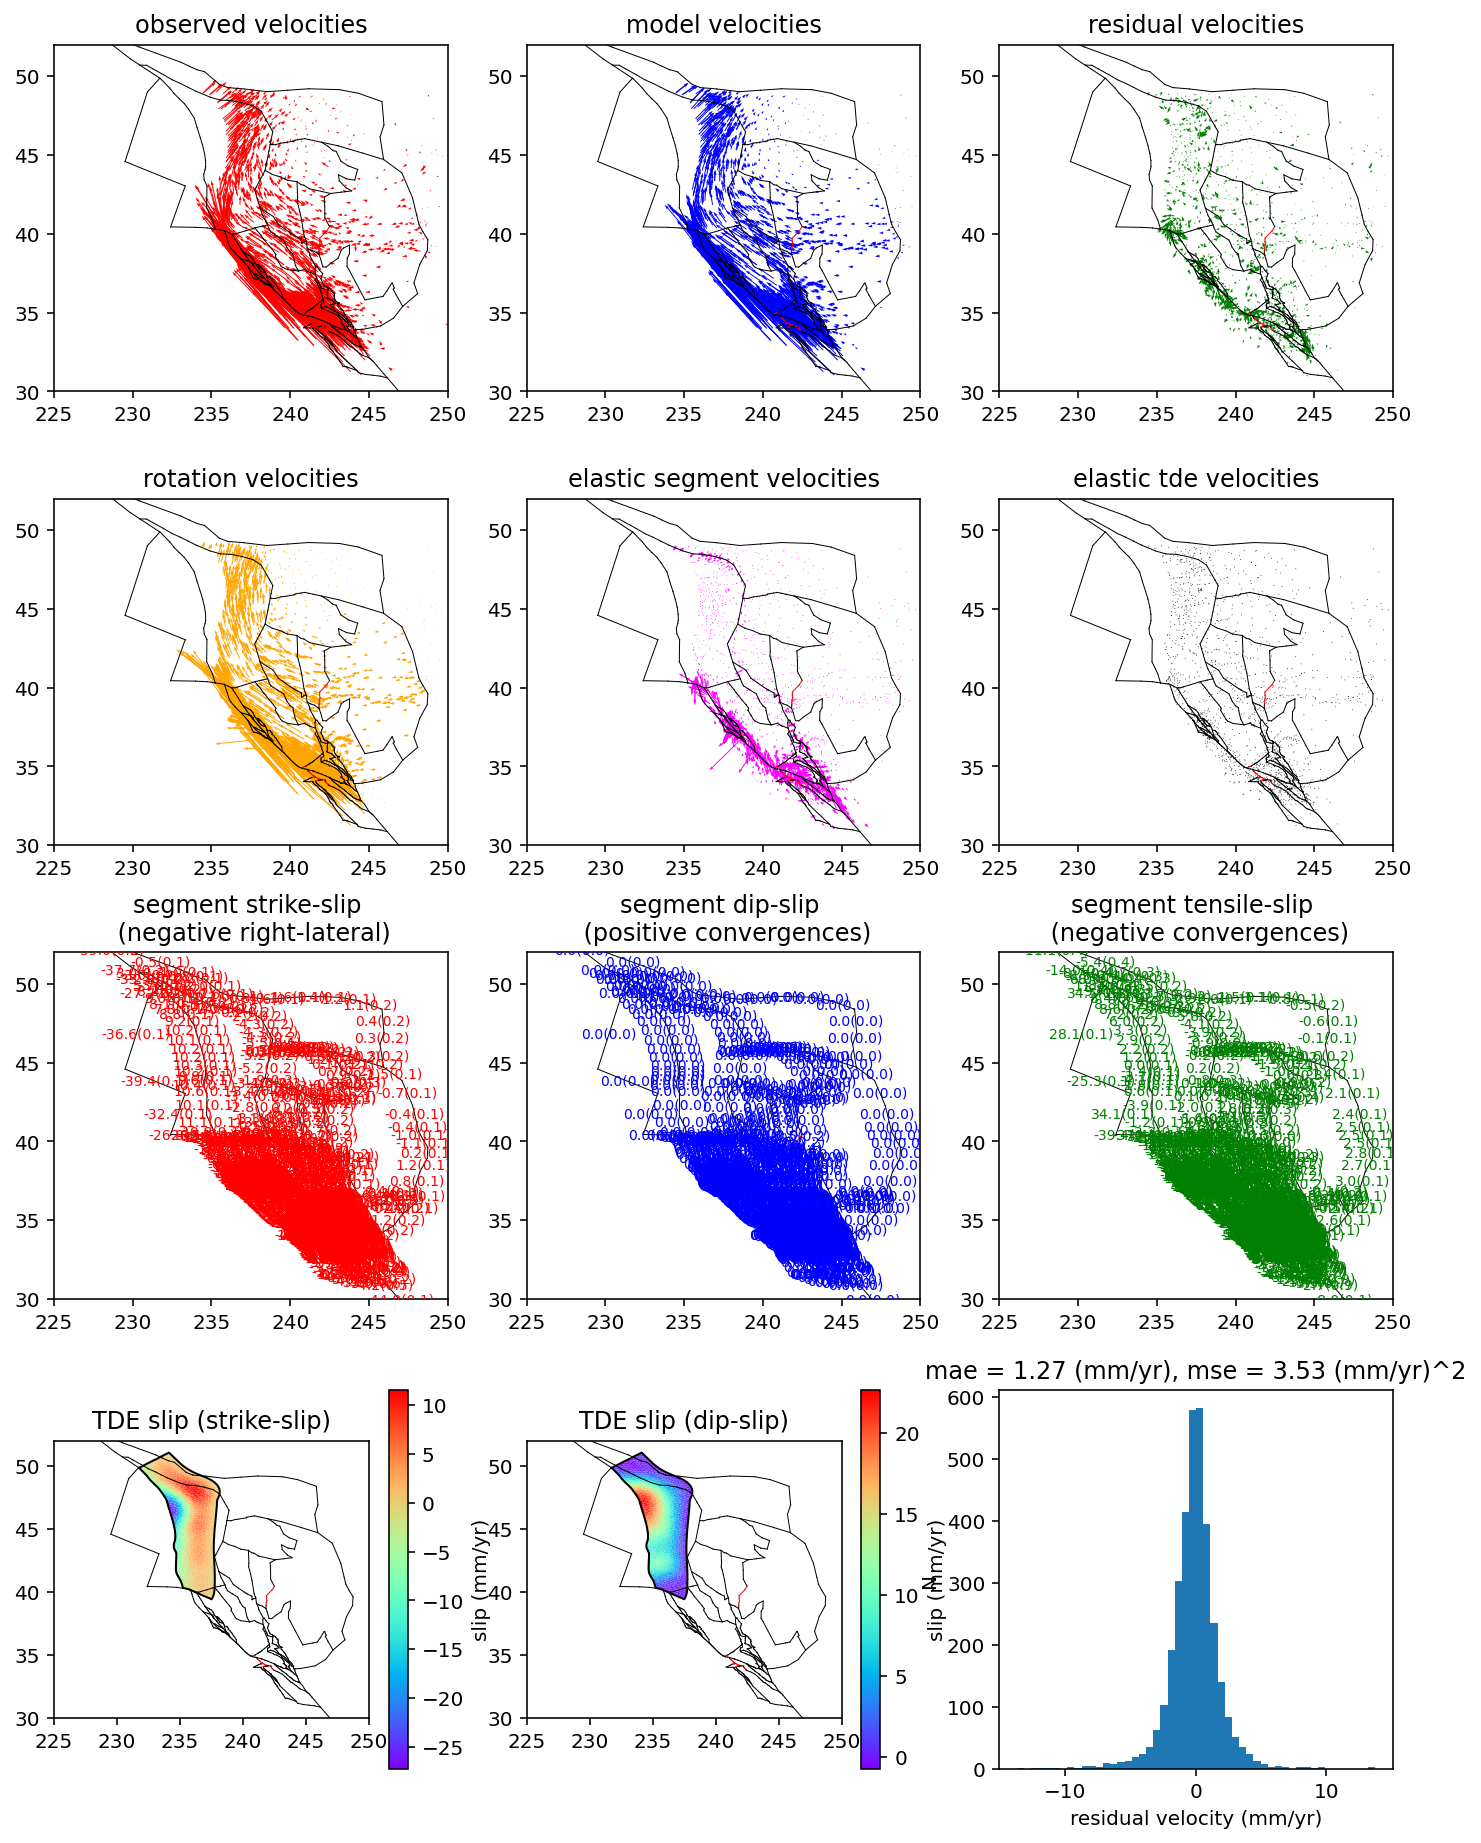

2023-02-20 23:38:50.108 | SUCCESS  | celeri.celeri:plot_estimation_summary:4544 - Wrote figures../runs/2023-02-20-23-04-03/plot_estimation_summary.(pdf, png)


<Figure size 432x288 with 0 Axes>

In [40]:
celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation_eigen,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=command.quiver_scale,
)

In [ ]:
a = eigenvectors_two_component @ estimation_eigen.state_vector[3 * n_blocks : :]

In [ ]:
meshes[0]

In [ ]:
np.linalg.cond(operator_eigen)

In [ ]:
plt.figure(figsize=(40, 10))
# plt.imshow(np.log10(np.abs(operators.tde_slip_rate_constraints[0] + 1e-1)))
plt.spy(operators.tde_slip_rate_constraints[0])
plt.colorbar()
plt.show()

In [ ]:
plt.plot(np.sum(operators.tde_slip_rate_constraints[0], axis=1), "r+")

In [ ]:
plt.figure(figsize=(10, 20))
plt.imshow(np.log10(np.abs(estimation_eigen.operator)))

plt.imshow(operators.tde_slip_rate_constraints[0] @ eigenvectors_two_component)

plt.show()

In [ ]:
operators.tde_slip_rate_constraints[0].shape

In [ ]:
meshes[0].keys()

In [ ]:
meshes[0].n_tde_constraints

In [ ]:
2 * (sum(meshes[0].bot_elements) + sum(meshes[0].side_elements))

In [ ]:
plt.plot(data_vector_eigen[-172:-1], "b+")

In [ ]:
# BUG: TDE constaints are not being applied properly
asdf = (
    operators.tde_slip_rate_constraints[0]
    @ eigenvectors_two_component
    @ estimation_eigen.state_vector[3 * n_blocks : :]
)

In [ ]:
asdf.shape